<center><h1> <span style="color:red">Classify Song Genres from Audio Data </span> </h1></center>

## R√©aliser par : 
 <ul>
<li><i> ibtissem BOUZIDI 3 DNI 2</i> </li>
<li> <i> Sabrine HOIYA 3 DNI 2 </i> </li>
    </ul>
    <center><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/iphone_music.jpg" alt="Project Image Record" width="200px"></center>

<center><h1> <span style="color:red">Probl√©matique</span> </h1></center>
<center><img src="intro.png"  width="1000px"/></center>

<center><h1> <span style="color:red">Solution</span> </h1></center>
<center><img src="idee.png"  width="1000px"/></center>

**<div class="alert alert-success"> <span style="color:#8A2BE2">Objectif du projet </span> </div>**

* Parcourir un ensemble de donn√©es compil√©es par un groupe de recherche connu sous le nom de The Echo Nest.  
* Nettoyer nos donn√©es.
* Effectuer une visualisation exploratoire des donn√©es
* Appliquer des algorithmes d'apprentissage automatique, tels que les <span style="color:#8A2BE2">arbres de d√©cision  </span>et la <span style="color:#8A2BE2">r√©gression logistique </span> pour de classer les chansons en tant que <i> ¬´¬†Hip-Hop¬†¬ª</i> ou <i>¬´¬†Rock¬†¬ª</i>

<div class="alert alert-block alert-danger"> <span style="color:#800000">Partie 1 : Pr√©-Traitement des donn√©es</span> </div>


### 1/ Pr√©parer notre jeu de donn√©es:
* Une chanson ne se limite pas √† son titre, son artiste et le nombre d'√©coutes. Nous avons un autre ensemble de donn√©es qui pr√©sente des caract√©ristiques musicales de chaque piste telles que la danse et l'acoustique sur une √©chelle de -1 √† 1. qui sont dans des formats diff√©rents¬†et dans notre cas nous avons travaill√© avec CSV


Commen√ßons par cr√©er deux pandas DataFrames √† partir de ces fichiers que nous pouvons fusionner afin d'avoir des fonctionnalit√©s et des √©tiquettes (souvent √©galement appel√©es X et y) pour la classification ult√©rieure.

In [2]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')
tracks.head(2)

track_id  bit_rate  comments composer         date_created  \
0       135    256000         1      NaN  2008-11-26 01:43:26   
1       136    256000         1      NaN  2008-11-26 01:43:35   

         date_recorded  duration  favorites genre_top    genres  ...  \
0  2008-11-26 00:00:00       837          0      Rock  [45, 58]  ...   
1  2008-11-26 00:00:00       509          0      Rock  [45, 58]  ...   

  information interest  language_code  \
0         NaN     2484             en   
1         NaN     1948             en   

                                             license listens  lyricist number  \
0  Attribution-NonCommercial-ShareAlike 3.0 Inter...    1832       NaN      0   
1  Attribution-NonCommercial-ShareAlike 3.0 Inter...    1498       NaN      0   

   publisher tags                       title  
0        NaN   []                Father's Day  
1        NaN   []  Peel Back The Mountain Sky  

[2 rows x 21 columns]

In [3]:
# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json',precise_float = True)
echonest_metrics.head(4)

track_id  acousticness  danceability    energy  instrumentalness  liveness  \
0         2      0.416675      0.675894  0.634476          0.010628  0.177647   
1         3      0.374408      0.528643  0.817461          0.001851  0.105880   
2         5      0.043567      0.745566  0.701470          0.000697  0.373143   
3        10      0.951670      0.658179  0.924525          0.965427  0.115474   

   speechiness    tempo   valence  
0     0.159310  165.922  0.576661  
1     0.461818  126.957  0.269240  
2     0.124595  100.260  0.621661  
3     0.032985  111.562  0.963590

In [4]:
# Merge the track_id and genre_top columns of tracks and echonest_metrics on track_id values
echo_tracks = pd.merge(left = tracks[['track_id', 'genre_top']], right=echonest_metrics, on='track_id')
echo_tracks.head(2)

track_id genre_top  acousticness  danceability    energy  instrumentalness  \
0       153      Rock      0.988306      0.255661  0.979774          0.973006   
1       154      Rock      0.970135      0.352946  0.023852          0.957113   

   liveness  speechiness   tempo   valence  
0  0.121342     0.051740  90.241  0.034018  
1  0.113261     0.032177  53.758  0.035632

In [5]:
# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   genre_top         4802 non-null   object 
 2   acousticness      4802 non-null   float64
 3   danceability      4802 non-null   float64
 4   energy            4802 non-null   float64
 5   instrumentalness  4802 non-null   float64
 6   liveness          4802 non-null   float64
 7   speechiness       4802 non-null   float64
 8   tempo             4802 non-null   float64
 9   valence           4802 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


## 2/ Relations par paires entre variables continues:
Il faut √©viter d'utiliser des variables qui ont de fortes corr√©lations les unes avec les autres, ainsi la redondance- pour plusieurs raisons:
<div class="alert alert-success"> <span style="color:#707000">
 <ul>
<li><i> Pour garder le mod√®le simple et am√©liorer l'interpr√©tabilit√© (surapprentissage).</i> </li>
<li> <i>Lorsque nos Datasets sont tr√®s volumineux, l'utilisation de moins de fonctionnalit√©s peut consid√©rablement acc√©l√©rer notre temps de calcul.</i> </li>
    </ul>
 </span></div>


In [6]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

<span style="color:orange"><b>Ici, nous pouvons voir une corr√©lation int√©ressante entre danceability et valence, mais elle n'est pas assez forte.</b></span>

## 3/ Normaliser les donn√©es
&#9888; &#x26A0; Simplifier nos mod√®les et les fonctionnalit√©s n√©cessaire pour obtenir le meilleur r√©sultat.<br>
&#x2611; Utiliser une approche pour r√©duire le nombre de caract√©ristiques appel√©e Analyse en Composantes Principales (ACP) est une m√©thode de <code>dimensionality reduction</code>.

* <span style="color:red"><b>Probleme:</b></span><br>
<i>PCA utilise la variance absolue d'une caract√©ristique pour faire pivoter les donn√©es, une caract√©ristique avec une plage de valeurs plus large dominera et biaisera l'algorithme par rapport aux autres caract√©ristiques</i> <br>
* <span style="color:#0000C0"><b>Solution:</b></span><br>
<i>Il existe plusieurs m√©thodes, mais une m√©thode courante consiste √† utiliser la standardisation , de sorte que toutes les caract√©ristiques aient une moyenne = 0 et un √©cart type = 1. </i>

In [7]:
# Define our features 
features = echo_tracks.drop(['genre_top', 'track_id'], axis = 1)
# Define our labels
labels = echo_tracks['genre_top']
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler
# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)
scaler.fit_transform(features)

array([[ 1.36170559, -0.98589622,  1.45332318, ..., -0.36415677,
        -1.07200261, -1.57310227],
       [ 1.31234237, -0.45568108, -2.46398518, ..., -0.49822414,
        -2.14506572, -1.5670495 ],
       [ 1.34364478, -1.60400213,  1.17609079, ..., -0.11890299,
        -1.022854  , -1.57194929],
       ...,
       [-1.29470431,  1.17682795,  0.13265633, ...,  0.85182206,
        -0.93541008, -0.07941825],
       [-1.13869115, -0.02253433,  0.57117905, ...,  1.40951543,
         1.31301348,  0.47513794],
       [-0.90611434,  1.10148973,  0.56322452, ...,  1.36030881,
        -1.43669053,  0.76217464]])

## 4/ Analyse en Composantes Principales sur nos donn√©es √† l'√©chelle: 
Nous avons pr√©trait√© nos donn√©es, nous sommes pr√™ts √† utiliser la PCA pour d√©terminer de combien nous pouvons r√©duire la dimensionnalit√© de nos donn√©es. On utilise <strong>scree-plots</strong> et <strong>cumulative explained ratio plots</strong> 

Les <strong>scree-plots</strong> affichent le nombre de composants par rapport √† la variance expliqu√©e par chaque composant, tri√©s par ordre d√©croissant de variance. 
* Les scree-plots nous aident √† mieux comprendre quels composants expliquent une quantit√© suffisante de variance dans nos donn√©es. 

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Obtenez nos rapport de variance expliqu√©s de PCA en utilisant toutes les features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
#exp_variance

array([0.24297674, 0.18044316, 0.13650309, 0.12994089, 0.11056248,
       0.08302245, 0.06923783, 0.04731336])

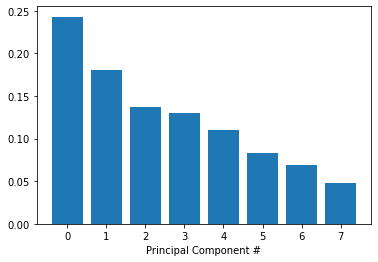

In [9]:
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')
plt.show()

## 5/ Visualisation plus pouss√©e de l'ACP:
<p>üò£ Malheureusement, il ne semble pas y avoir de coude clair dans ce trac√©, ce qui signifie qu'il n'est pas simple de trouver le nombre de dimensions intrins√®ques √† l'aide de cette m√©thode. Au lieu de cela, nous pouvons examiner le graphique de la variance expliqu√©e cumulative pour d√©terminer combien de caract√©ristiques sont n√©cessairesdisons, environ 90 % de la variance.</p>

In [10]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)
cum_exp_variance

array([0.24297674, 0.4234199 , 0.55992299, 0.68986388, 0.80042636,
       0.88344881, 0.95268664, 1.        ])

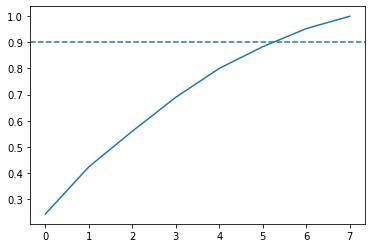

In [11]:
# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(8),cum_exp_variance).y
 
ax.axhline(y=0.9, linestyle='--')
plt.show()

In [12]:
# choose the n_components where about 85% of our variance can be explained
n_components = 7

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [13]:
scaled_train_features.shape

(4802, 8)

In [14]:
pca_projection.shape

(4802, 7)

> Nous pouvons maintenant utiliser PCA de dimension inf√©rieure des donn√©es pour classer les chansons en genres.

## 6/ Arbre de d√©cision:

> Un arbre de d√©cision est un outil d'aide √† la d√©cision repr√©sentant un ensemble de choix sous la forme graphique d'un arbre. Les diff√©rentes d√©cisions possibles sont situ√©es aux extr√©mit√©s des branches, et sont atteintes en fonction de d√©cisions prises √† chaque √©tape


<center><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/simple_decision_tree.png" alt="Decision Tree Flow Chart Example" width="350px"></center>


* <span style="color:red"><b>Etape 1:</b></span> Diviser notre ensemble de donn√©es en sous-ensembles ¬´ train ¬ª et ¬´ test ¬ª.

In [17]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, stratify = labels)

# Train our decision tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_features, train_labels)


* <span style="color:red"><b>Etape 2:</b></span> Pr√©diction des donn√©es √† partir de l'arbre entra√Æner.

In [19]:
# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

* Score de classification de pr√©cision.

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels_tree)

0.8684429641965029

<span style="color:orange"><b>L'ensemble d'√©tiquettes pr√©dit pour un √©chantillon correspondre 80% √† l'ensemble d'√©tiquettes correspondant dans test_labels.</b></span>

* Mais pourquoi il ne sont pas exact ü§îü§î??? 

In [22]:
labels.value_counts()

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

> Nos donn√©es sont d√©s√©quilibr√©es, donc ici la pr√©cision n'est pas vraiment une bonne mesure. Regardons la matrice de confusion.

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, pred_labels_tree)

array([[149,  79],
       [ 79, 894]], dtype=int64)

> Il faut tester au moins quelques autres algorithmes et de trouver qui convient le mieux √† nos donn√©es, et qui seront encore plus performants 

## 7/ Arbre de d√©cision vs R√©gression logistique
Parfois, le plus simple est le meilleur, et nous allons donc commencer par appliquer la r√©gression logistique . La r√©gression logistique utilise ce qu'on appelle la fonction logistique pour calculer les chances qu'un point de donn√©es donn√© appartienne √† une classe donn√©e.</br>

<center><img src="https://datascientest.com/wp-content/uploads/2020/11/illu_regression_blog-16-1024x562.png" alt="Decision Tree Flow Chart Example" width="350px"></center>


Une fois que nous avons les deux mod√®les, nous pouvons les comparer sur quelques mesures de performance, telles que le taux de faux positifs et de faux n√©gatifs (ou combien de points sont class√©s de mani√®re inexacte).

In [23]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

* Cr√©er le rapport de classification pour les deux mod√®les

In [24]:
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.65      0.65      0.65       228
        Rock       0.92      0.92      0.92       973

    accuracy                           0.87      1201
   macro avg       0.79      0.79      0.79      1201
weighted avg       0.87      0.87      0.87      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.76      0.53      0.63       228
        Rock       0.90      0.96      0.93       973

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



## 8/ √âquilibrer nos donn√©es pour plus de performances :
Nos deux mod√®les fonctionnent de mani√®re similaire, avec une pr√©cision moyenne de 87 % chacun.
En regardant notre rapport de classification, nous pouvons voir que les chansons rock sont assez bien class√©es, mais les chansons hip-hop sont class√©es √† de mani√®re disproportionn√©e.

In [30]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']
rock_only.head()

track_id genre_top  acousticness  danceability    energy  instrumentalness  \
0       153      Rock      0.988306      0.255661  0.979774          0.973006   
1       154      Rock      0.970135      0.352946  0.023852          0.957113   
2       155      Rock      0.981657      0.142249  0.912122          0.967294   
3       169      Rock      0.989141      0.225978  0.722835          0.263076   
4       170      Rock      0.886660      0.298518  0.744333          0.920950   

   liveness  speechiness   tempo   valence  
0  0.121342     0.051740  90.241  0.034018  
1  0.113261     0.032177  53.758  0.035632  
2  0.363510     0.087527  91.912  0.034325  
3  0.092371     0.053406  94.322  0.028347  
4  0.139587     0.088781  97.880  0.073548

In [31]:
rock_only.shape, hop_only.shape

((3892, 10), (910, 10))

Echantillonnez les chansons rock pour qu'elles soient le m√™me nombre qu'il y a des chansons hip-hop

In [32]:
rock_only = rock_only.sample(n= hop_only.shape[0])
rock_only.shape, hop_only.shape

((910, 10), (910, 10))

In [33]:
# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])
rock_hop_bal.shape

(1820, 10)

In [35]:
# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,
                                                                            labels,
                                                                            stratify = labels,
                                                                            random_state=10)

##  L'√©quilibrage de notre ensemble de donn√©es am√©liore-t-il le biais du mod√®le ?
Nous avons maintenant √©quilibr√© notre ensemble de donn√©es, mais nous avons supprim√© de nombreux points de donn√©es qui auraient pu √™tre cruciaux pour l'entra√Ænement de nos mod√®les. 
* Testons pour voir si l'√©quilibrage de nos donn√©es am√©liore le biais du mod√®le vers la classification ¬´ Rock ¬ª tout en conservant les performances globales de la classification.

In [37]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

In [46]:
# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.78      0.80       227
        Rock       0.79      0.83      0.81       228

    accuracy                           0.80       455
   macro avg       0.81      0.80      0.80       455
weighted avg       0.81      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.87      0.78      0.82       227
        Rock       0.80      0.88      0.84       228

    accuracy                           0.83       455
   macro avg       0.84      0.83      0.83       455
weighted avg       0.84      0.83      0.83       455



<center><h1> <span style="color:red"> validation crois√©e pour √©valuer nos mod√®les</span> </h1></center>
Succ√®s! L'√©quilibrage de nos donn√©es a supprim√© le biais en faveur de la classe la plus r√©pandue. Pour avoir une bonne id√©e de la performance r√©elle de nos mod√®les, nous pouvons appliquer ce qu'on appelle la validation crois√©e (CV). Cette √©tape nous permet de comparer les mod√®les de fa√ßon plus rigoureuse

In [47]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(n_splits=10, random_state=10, shuffle=True)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, labels, cv = kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv = kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score),
      "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7780219780219779 Logistic Regression: 0.8456043956043956


<div class="alert alert-block alert-danger"> <span style="color:#800000">Type de diapo
Nous pouvons voir ici que notre mod√®le de r√©gression logistique simple a donn√© de meilleurs r√©sultats que le mod√®le d'arbre de d√©cision sur les donn√©es √©quilibr√©es. Nous pouvons essayer des mod√®les plus avanc√©s comme Random Forest et SVM pour am√©liorer nos r√©sultats.</span> </div>
